In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions
from tqdm import trange
from open_atmos_jupyter_utils import show_plot, show_anim
from matplotlib import animation

In [ ]:
plt.rcParams.update({
    "font.size": 14,       # domyślny rozmiar czcionki
    "axes.titlesize": 16,  # tytuły wykresów
    "axes.labelsize": 14,  # etykiety osi
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})


Obrazek

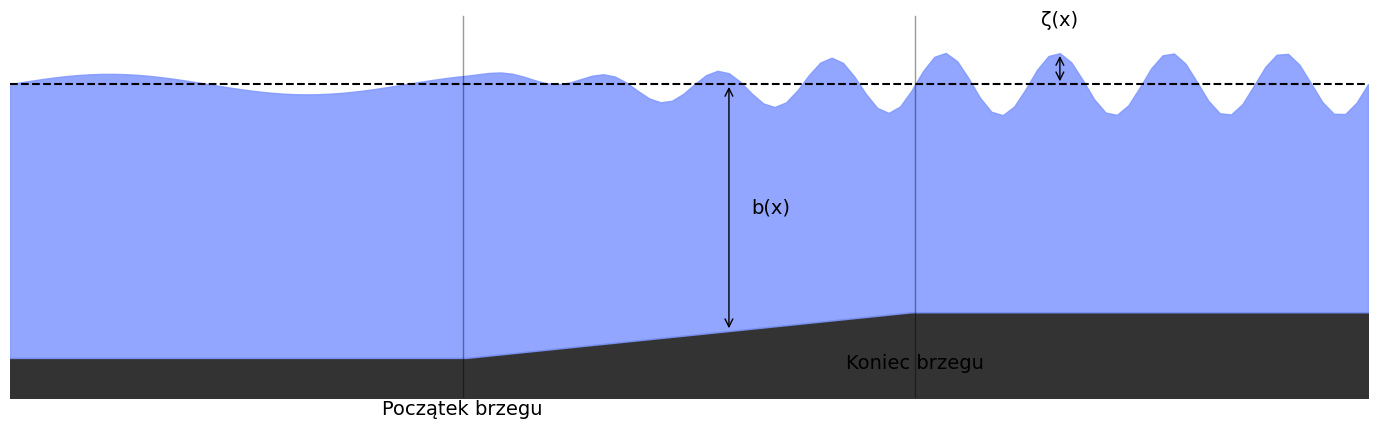

In [ ]:
Lx_km = 120
dx_km = 1
Nx = int(Lx_km / dx_km)
x = np.linspace(0, Lx_km, Nx)

deep_end = 40
shelf_end = 80

H_deep = 1.0
H_shallow = 0.2

bathy = np.zeros(Nx)
bathy[:deep_end] = H_deep
bathy[deep_end:shelf_end] = np.linspace(H_deep, H_shallow, shelf_end - deep_end)
bathy[shelf_end:] = H_shallow


k1 = 2 * np.pi / 35
k2 = 2 * np.pi / 10

eta1 = 0.18 * np.sin(k1 * x)
eta2 = 0.55 * np.sin(k2 * x)

alpha = np.clip((x - deep_end) / (shelf_end - deep_end), 0, 1)
eta = (1 - alpha) * eta1 + alpha * eta2

BOTTOM_SHIFT = -2.8
WATER_LIFT = 1.0

eta_viz = eta + WATER_LIFT
bathy_viz = -bathy + BOTTOM_SHIFT

plt.figure(figsize=(14, 4.5))

plt.fill_between(x, bathy_viz, -4.5, color="#333333")

plt.fill_between(x, eta_viz, bathy_viz, color="#7f97ff", alpha=0.85)


z0 = WATER_LIFT
plt.axhline(z0, linestyle="--", color="black")

ix_zeta = 92
plt.annotate(
    "",
    xy=(x[ix_zeta], eta_viz[ix_zeta]),
    xytext=(x[ix_zeta], z0),
    arrowprops=dict(arrowstyle="<->", lw=1),
)

plt.text(
    x[ix_zeta],
    eta_viz[ix_zeta] + 0.4,  
    "ζ(x)",
    ha="center",
    va="bottom"
)

ix_h = 63
plt.annotate(
    "",
    xy=(x[ix_h], z0),
    xytext=(x[ix_h], bathy_viz[ix_h]),
    arrowprops=dict(arrowstyle="<->", lw=1),
)
plt.text(x[ix_h] + 2, 0.5*(z0 + bathy_viz[ix_h]), "b(x)", va="center")


for pos, label in [(deep_end, "Początek brzegu"), (shelf_end, "Koniec brzegu")]:
    plt.plot([pos, pos], [-4.5, 2.2], color="black", linewidth=1, alpha=0.4)
    plt.text(pos, bathy_viz[pos] - 1.0, label, ha="center")


plt.ylim(-4.5, 2.3)
plt.xlim(0, Lx_km)
plt.axis("off")

plt.tight_layout()
plt.savefig("../fig/shoaling_diagram.pdf", format="pdf", bbox_inches="tight")
plt.show()


Solver

In [2]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, bathymetry: np.ndarray, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }
        self.bathymetry = bathymetry

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()
    
    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h'] - self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None) 
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[( 
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2 
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        flag = False
        for it in trange(nt + 1,desc="Symulacja"): 
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])

                    eta_right = (
                        self.solvers["h"].advectee.get()[-1, :] -
                        self.bathymetry[-1, :]
                    )

                    if np.max(eta_right) > 1e-4:  
                        print("\nSymulacja zatrzymana — fala dotarła do prawego brzegu.\n")
                        for key in self.solvers.keys():
                            output[key].append(self[key].copy())
                        flag = True
                        break
                if flag == True:
                    break
            if flag == True:
                break

            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

Symulacja sprawdzająca

In [6]:
Lx_km = 120.0      
dx_km = 1.0        
Nx = int(Lx_km / dx_km)
Ny = 20            

grid = (Nx, Ny)

H_deep = 1.0       
H_shallow = 0.05   
deep_end = 40       
shelf_end = 80      

bathy_1d = np.zeros(Nx)

bathy_1d[:deep_end] = H_deep

bathy_1d[deep_end:shelf_end] = np.linspace(
    H_deep,
    H_shallow,
    shelf_end - deep_end
)

bathy_1d[shelf_end:] = H_shallow

bathymetry = np.tile(bathy_1d.reshape(-1, 1), (1, Ny))

A = 0.05 * H_deep   
x0 = 20            
sigma = 5          

x = np.arange(Nx)

# 1-D profil wysokości swobodnej powierzchni
eta_1d = A * np.exp(-(x - x0)**2 / (2 * sigma**2))

# „płaska” w Y – kopiujemy profil do wszystkich wierszy
eta_2d = np.tile(eta_1d.reshape(-1, 1), (1, Ny))


h_initial = bathymetry + eta_2d


g = 10.0
dt_over_dx = 0.005   
dt_over_dy = 0.005

integrator = ShallowWaterEquationsIntegrator(
    h_initial=h_initial,
    bathymetry=bathymetry
)

output = integrator(
    nt=10000,                
    g=g,
    dt_over_dxy=(dt_over_dx, dt_over_dy),
    outfreq=10               
)

Symulacja: 100%|██████████| 10001/10001 [04:43<00:00, 35.34it/s]


Porównanie z prawem Greena

In [ ]:
plt.rcParams.update({
    "font.size": 14,       # domyślny rozmiar czcionki
    "axes.titlesize": 18,  # tytuły wykresów
    "axes.labelsize": 14,  # etykiety osi
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 14
})

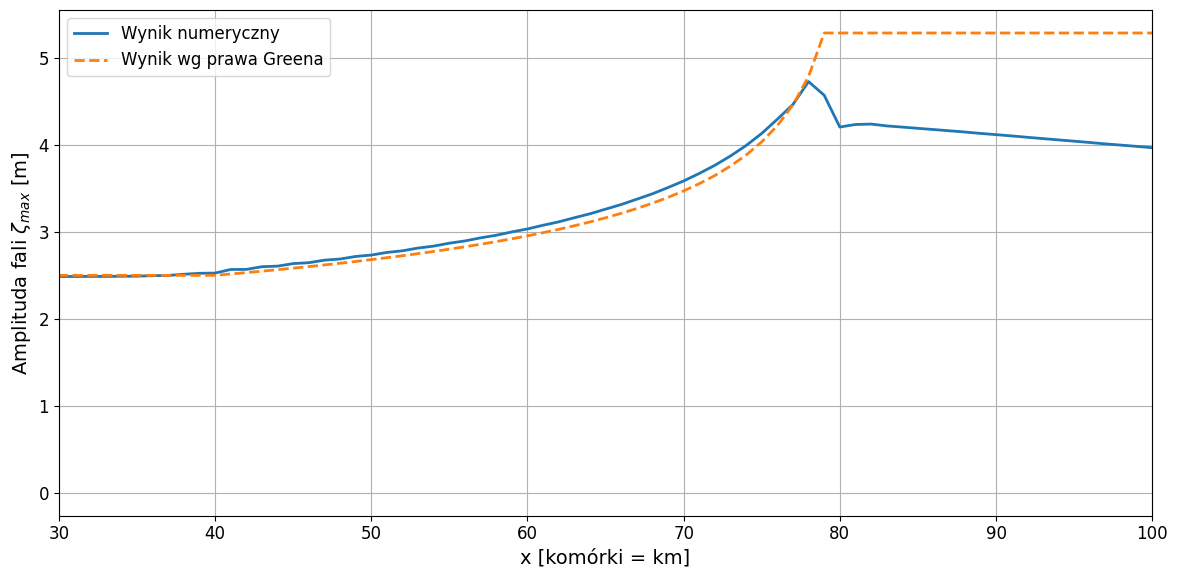

In [12]:
def first_arrival_amplitude(eta, threshold=1e-4, window=300):
    """
    Liczy amplitudę pierwszej fali (bez odbić):
    - threshold: próg detekcji nadejścia fali
    - window: ile klatek po nadejściu przeszukać
    """
    Nt, Nx = eta.shape
    result = np.zeros(Nx)

    for ix in range(Nx):
        col = eta[:, ix]
        arrived = np.where(col > threshold)[0]

        if len(arrived) == 0:
            continue

        t0 = arrived[0]           
        t1 = min(t0 + window, Nt)    
        result[ix] = col[t0:t1].max()

    return result


h_out = output["h"] 
Nt = len(h_out)
bath = bathymetry

eta_num = np.array([h - bath for h in h_out])

Ny_mid = eta_num.shape[2] // 2
Nt, Nx, _ = eta_num.shape

eta_mid = eta_num[:, :, Ny_mid]  

threshold = 1e-3        
window_frames = 150     

A_num_first = first_arrival_amplitude(eta_mid, threshold, window_frames)

x0 = 20                 
A_initial = eta_mid[0, x0]    
A0 = A_initial / 2            

H0 = bath[x0, Ny_mid]
H_x = bath[:, Ny_mid]

A_green = A0 * (H0 / H_x)**0.25

plt.figure(figsize=(12,6))
plt.plot(A_num_first*100, label="Wynik numeryczny", linewidth=2)
plt.plot(A_green*100, label="Wynik wg prawa Greena", linestyle="--", linewidth=2)

plt.xlabel("x [komórki = km]")
plt.xlim(30,100)
plt.ylabel(r"Amplituda fali $\zeta_{max}$ [m]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../fig/low_gradient_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
plt.rcParams.update({
    "font.size": 14,       # domyślny rozmiar czcionki
    "axes.titlesize": 12,  # tytuły wykresów
    "axes.labelsize": 12,  # etykiety osi
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 11
})

Animacja zapisana jako fig/tsunami.gif


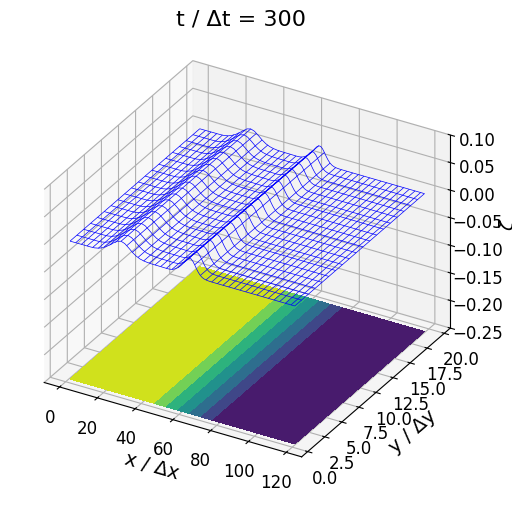

In [13]:
# --- Animowana funkcja plotująca ---
def plot_frame(ax, frame, *, zlim=(-.25, 0.1)):
    ax.clear()  # tylko czyścimy axes, NIE całą figurę

    psi = output['h'][frame] - bathymetry
    xi, yi = np.indices(psi.shape)

    ax.plot_wireframe(xi+.5, yi+.5, psi, color='blue', linewidth=.5)
    ax.set(zlim=zlim, proj_type='ortho', title=f"t / Δt = {frame}", zlabel=r"$\zeta$")

    for axis in ('x', 'y'):
        getattr(ax, f'set_{axis}label')(f"{axis} / Δ{axis}")

    # bathymetria jako contour
    cf = ax.contourf(
        xi+.5, yi+.5, bathymetry,
        zdir='z', offset=zlim[0]
    )

    return ax


frames = range(300, len(output['h']), 10)

# --- Przygotowanie figury i osi ---
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# --- aktualizacja dla animacji ---
def update(frame):
    plot_frame(ax, frame)
    return ax,

# --- Tworzenie animacji ---
anim = animation.FuncAnimation(
    fig,
    update,
    frames=frames,
    blit=False
)


# --- Zapis ---
anim.save("../fig/tsunami.gif", writer="pillow", fps=10)


print("Animacja zapisana jako fig/tsunami.gif")

Analiza zależności maskymalnej wysokości fali tsunami od stromości wybrzeża

In [3]:
deep_end_list = [40, 50, 70]  
shelf_end = 80                        
H_deep = 1.0
H_shallow = 0.05

results = {}     
max_values = {}    

def compute_bathymetry(deep_end):
    bathy = np.zeros(Nx)
    bathy[:deep_end] = H_deep
    bathy[deep_end:shelf_end] = np.linspace(H_deep, H_shallow, shelf_end - deep_end)
    bathy[shelf_end:] = H_shallow
    return np.tile(bathy.reshape(-1,1),(1,Ny))


def first_arrival_amplitude(eta, threshold=1e-3, window=300):
    Nt, Nx = eta.shape
    result = np.zeros(Nx)
    for ix in range(Nx):
        col = eta[:, ix]
        arrived = np.where(col > threshold)[0]
        if len(arrived) == 0:
            continue
        t0 = arrived[0]
        t1 = min(t0 + window, Nt)
        result[ix] = col[t0:t1].max()
    return result


for deep_end in deep_end_list:
    print(f"\n=== Symulacja dla deep_end = {deep_end} km ===")

    Lx_km = 120.0      
    dx_km = 1.0        
    Nx = int(Lx_km / dx_km)
    Ny = 20            

    grid = (Nx, Ny)
    
    bathymetry = compute_bathymetry(deep_end)

    A = 0.05 * H_deep  
    x0 = 20            
    sigma = 5          

    x = np.arange(Nx)

    # 1-D profil wysokości swobodnej powierzchni
    eta_1d = A * np.exp(-(x - x0)**2 / (2 * sigma**2))

    # „płaska” w Y – kopiujemy profil do wszystkich wierszy
    eta_2d = np.tile(eta_1d.reshape(-1, 1), (1, Ny))


    h_initial = bathymetry + eta_2d

    g = 9.81
    dt_over_dx = 0.005
    dt_over_dy = 0.005

    integrator = ShallowWaterEquationsIntegrator(
        h_initial=h_initial,
        bathymetry=bathymetry
    )

    output = integrator(
        nt=10000,
        g=g,
        dt_over_dxy=(dt_over_dx, dt_over_dy),
        outfreq=10
    )

    h_out = output["h"]
    eta_num = np.array([h - bathymetry for h in h_out])
    Ny_mid = eta_num.shape[2] // 2
    eta_mid = eta_num[:, :, Ny_mid]

    A_num_first = first_arrival_amplitude(eta_mid)

    results[deep_end] = A_num_first * 100

    max_amp = A_num_first[70:90].max()
    max_values[deep_end] = max_amp * 100

    print(f"Max amplituda w zakresie x=70–90: {max_amp:.5f}")


=== Symulacja dla deep_end = 40 km ===


Symulacja: 100%|██████████| 10001/10001 [05:54<00:00, 28.20it/s]


Max amplituda w zakresie x=70–90: 0.04727

=== Symulacja dla deep_end = 50 km ===


Symulacja: 100%|██████████| 10001/10001 [04:48<00:00, 34.71it/s]


Max amplituda w zakresie x=70–90: 0.04755

=== Symulacja dla deep_end = 70 km ===


Symulacja: 100%|██████████| 10001/10001 [04:52<00:00, 34.16it/s]

Max amplituda w zakresie x=70–90: 0.05029


In [ ]:
plt.rcParams.update({
    "font.size": 14,       # domyślny rozmiar czcionki
    "axes.titlesize": 18,  # tytuły wykresów
    "axes.labelsize": 14,  # etykiety osi
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 14
})

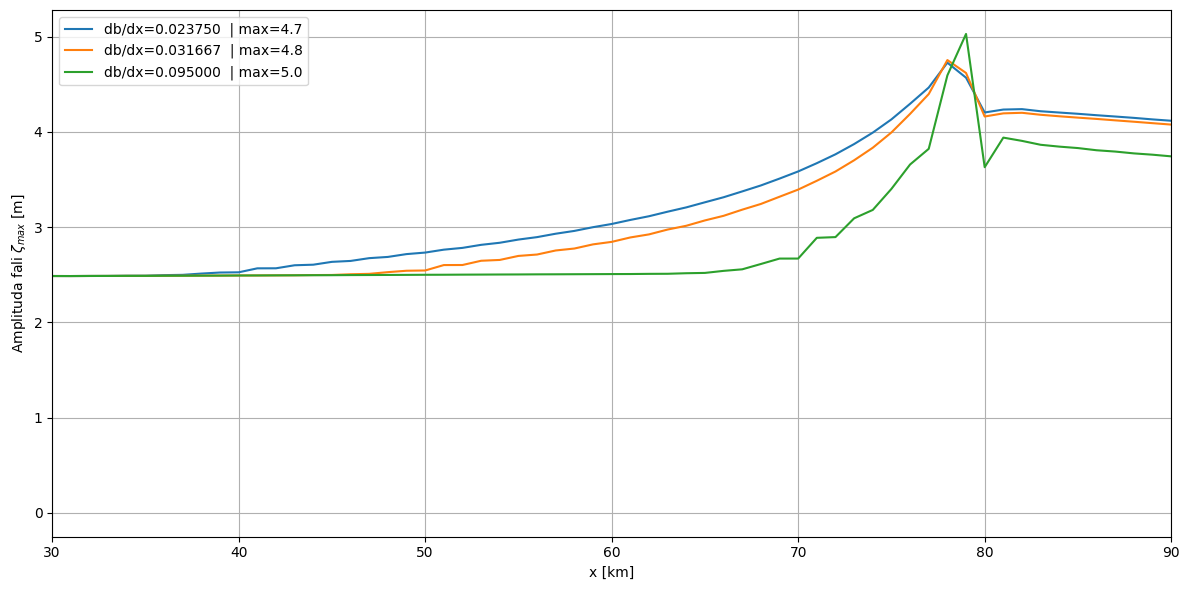

In [5]:
plt.figure(figsize=(12,6))

for deep_end in deep_end_list:
    plt.plot(
        results[deep_end],
        label=f"db/dx={(0.95/(shelf_end - deep_end)):2f}  | max={(max_values[deep_end]):.1f}"
    )

plt.xlabel("x [km]")
plt.ylabel(r"Amplituda fali $\zeta_{max}$ [m]")
plt.xlim(30, 90)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../fig/results1.pdf", format="pdf", bbox_inches="tight")
plt.show()


Symulacja dla dwukrotnie zwiększonej rozdzielczości czasowej

In [ ]:
deep_end_list = [60, 140] 
shelf_end = 160                        
H_deep = 1.0
H_shallow = 0.05

results = {}    
max_values = {}  

def compute_bathymetry(deep_end):
    bathy = np.zeros(Nx)
    bathy[:deep_end] = H_deep
    bathy[deep_end:shelf_end] = np.linspace(H_deep, H_shallow, shelf_end - deep_end)
    bathy[shelf_end:] = H_shallow
    return np.tile(bathy.reshape(-1,1),(1,Ny))


def first_arrival_amplitude(eta, threshold=1e-3, window=300):
    Nt, Nx = eta.shape
    result = np.zeros(Nx)
    for ix in range(Nx):
        col = eta[:, ix]
        arrived = np.where(col > threshold)[0]
        if len(arrived) == 0:
            continue
        t0 = arrived[0]
        t1 = min(t0 + window, Nt)
        result[ix] = col[t0:t1].max()
    return result


for deep_end in deep_end_list:
    print(f"\n=== Symulacja dla deep_end = {deep_end/2} km ===")

    Lx_km = 120.0 
    dx_km = 0.5 
    Nx = int(Lx_km / dx_km)
    Ny = 40

    grid = (Nx, Ny)
    
    bathymetry = compute_bathymetry(deep_end)

    A = 0.05 * H_deep   
    x0 = 40            
    sigma = 10          

    x = np.arange(Nx)

    # 1-D profil wysokości swobodnej powierzchni
    eta_1d = A * np.exp(-(x - x0)**2 / (2 * sigma**2))

    # „płaska” w Y – kopiujemy profil do wszystkich wierszy
    eta_2d = np.tile(eta_1d.reshape(-1, 1), (1, Ny))


    h_initial = bathymetry + eta_2d

    g = 9.81
    dt_over_dx = 0.0025  
    dt_over_dy = 0.0025

    integrator = ShallowWaterEquationsIntegrator(
        h_initial=h_initial,
        bathymetry=bathymetry
    )

    output = integrator(
        nt=20000,
        g=g,
        dt_over_dxy=(dt_over_dx, dt_over_dy),
        outfreq=10
    )

    h_out = output["h"]
    eta_num = np.array([h - bathymetry for h in h_out])
    Ny_mid = eta_num.shape[2] // 2
    eta_mid = eta_num[:, :, Ny_mid]

    A_num_first = first_arrival_amplitude(eta_mid)

    results[deep_end] = A_num_first * 100

    max_amp = A_num_first[140:180].max()
    max_values[deep_end] = max_amp * 100

    print(f"Max amplituda w zakresie x=140–180: {max_amp:.5f}")


=== Symulacja dla deep_end = 60 km ===


Symulacja: 100%|██████████| 20001/20001 [11:25<00:00, 29.17it/s]


Max amplituda w zakresie x=70–90: 0.05046

=== Symulacja dla deep_end = 150 km ===


Symulacja: 100%|██████████| 20001/20001 [11:47<00:00, 28.27it/s]


Max amplituda w zakresie x=70–90: 0.04505


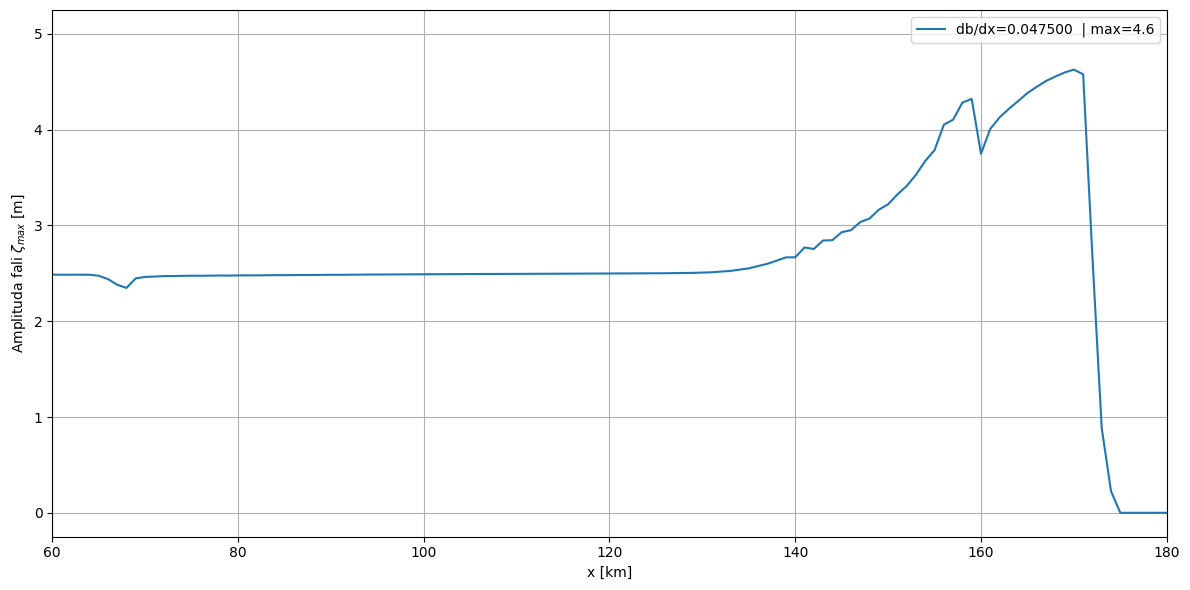

In [ ]:
plt.figure(figsize=(12,6))

for deep_end in deep_end_list:
    plt.plot(
        results[deep_end],
        label=f"db/dx={(0.95/(shelf_end - deep_end)):2f}  | max={(max_values[deep_end]):.1f}"
    )

plt.xlabel("x [km]")
plt.ylabel(r"Amplituda fali $\zeta_{max}$ [m]")
plt.xlim(60, 180)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../fig/results2.pdf", format="pdf", bbox_inches="tight")
plt.show()
